In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,random_split, TensorDataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Downloading QuickDraw Dataset in .npy Format

The QuickDraw dataset provides hand-drawn sketches stored in NumPy bitmap format (.npy). These files are already rasterized and normalized into matrices of size 28x28 with pixel values ranging from 0 to 1. Therefore:

No need for conversion to PIL (Python Imaging Library):
Since the data is already rasterized, we can directly use it for training a Convolutional Neural Network (CNN).

Straightforward loading with NumPy:
The .npy format is lightweight, fast to load, and compatible with libraries like PyTorch and TensorFlow.

In [2]:
import urllib.request

# Updated categories and label_dict sorted alphabetically
categories = ['apple', 'book', 'cannon', 'crayon', 'eye', 'face', 'flower',
              'nail', 'pear', 'piano', 'radio', 'spider', 'star', 'sun']

label_dict = {idx: category for idx, category in enumerate(categories)}

# Print the updated categories and label_dict
print("Categories:", categories)
print("Label Dictionary:", label_dict)


# Function to download data
def download_quickdraw_data(classes, data_dir='data'):
    os.makedirs(data_dir, exist_ok=True)  # Creates the directory if it does not exist
    base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    
    for class_name in classes:
        formatted_name = class_name.replace(' ', '_').lower()
        url = f"{base_url}{formatted_name}.npy"
        file_path = os.path.join(data_dir, f"{formatted_name}.npy")
        
        if not os.path.exists(file_path):  # Avoid duplicate downloads
            print(f"Downloading {url} to {file_path}")
            urllib.request.urlretrieve(url, file_path)
            print(f"Downloaded: {file_path}")
        else:
            print(f"File already exists: {file_path}")

# Downloads data for specified classes
download_quickdraw_data(categories)

# Load the downloaded data
import numpy as np

def load_quickdraw_data(classes, data_dir='data'):
    data = {}
    for idx, class_name in enumerate(classes):
        file_path = os.path.join(data_dir, f"{class_name}.npy")
        if os.path.exists(file_path):
            print(f"Loading {file_path}")
            data[class_name] = np.load(file_path)
        else:
            print(f"File not found: {file_path}")
    return data

# Loads data in NumPy format
quickdraw_data = load_quickdraw_data(categories)
print("Data loaded successfully!")


Categories: ['apple', 'book', 'cannon', 'crayon', 'eye', 'face', 'flower', 'nail', 'pear', 'piano', 'radio', 'spider', 'star', 'sun']
Label Dictionary: {0: 'apple', 1: 'book', 2: 'cannon', 3: 'crayon', 4: 'eye', 5: 'face', 6: 'flower', 7: 'nail', 8: 'pear', 9: 'piano', 10: 'radio', 11: 'spider', 12: 'star', 13: 'sun'}
File already exists: data/apple.npy
File already exists: data/book.npy
File already exists: data/cannon.npy
File already exists: data/crayon.npy
File already exists: data/eye.npy
File already exists: data/face.npy
File already exists: data/flower.npy
File already exists: data/nail.npy
File already exists: data/pear.npy
File already exists: data/piano.npy
File already exists: data/radio.npy
File already exists: data/spider.npy
File already exists: data/star.npy
File already exists: data/sun.npy
Loading data/apple.npy
Loading data/book.npy
Loading data/cannon.npy
Loading data/crayon.npy
Loading data/eye.npy
Loading data/face.npy
Loading data/flower.npy
Loading data/nail.npy

### Code for Visualizing QuickDraw Images

Visualizes a specified number of images from a given .npy file.

    Parameters:
    - file_path (str): Path to the .npy file containing image data.
    - num_images (int): Number of images to display (default is 6).

    Returns:
    - None: Displays the images using matplotlib.

Visualizing images from: apple.npy
Loaded data/apple.npy with shape: (144722, 784)


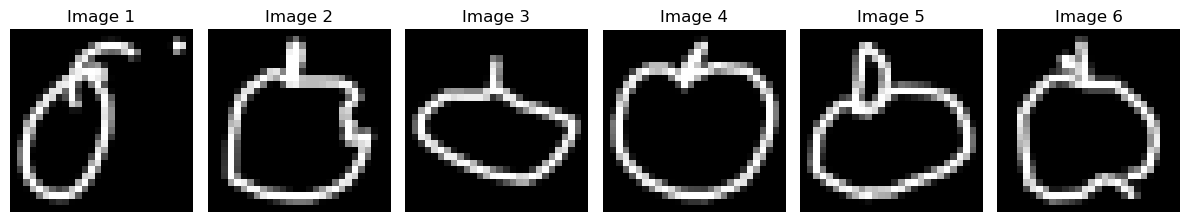

Visualizing images from: nail.npy
Loaded data/nail.npy with shape: (158593, 784)


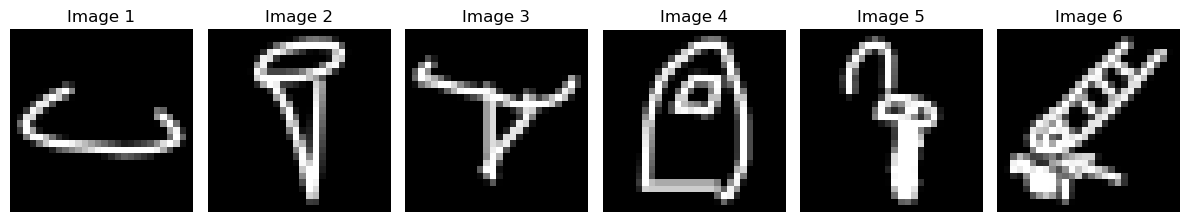

Visualizing images from: sword.npy
Loaded data/sword.npy with shape: (123802, 784)


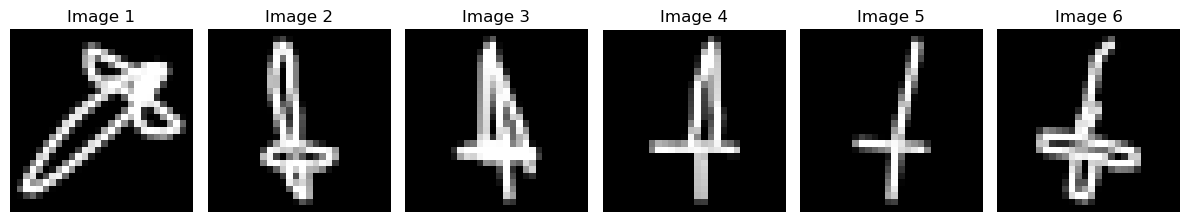

Visualizing images from: cannon.npy
Loaded data/cannon.npy with shape: (141394, 784)


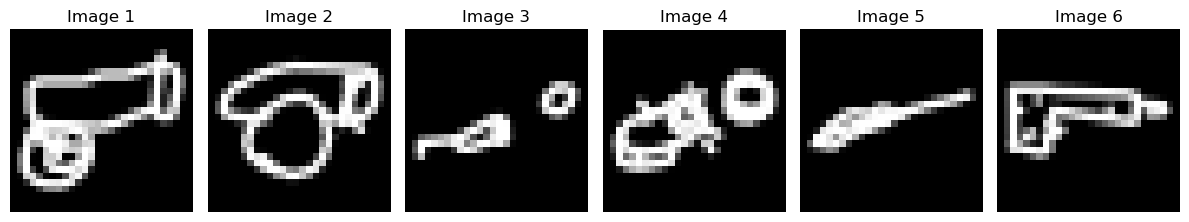

Visualizing images from: pear.npy
Loaded data/pear.npy with shape: (116904, 784)


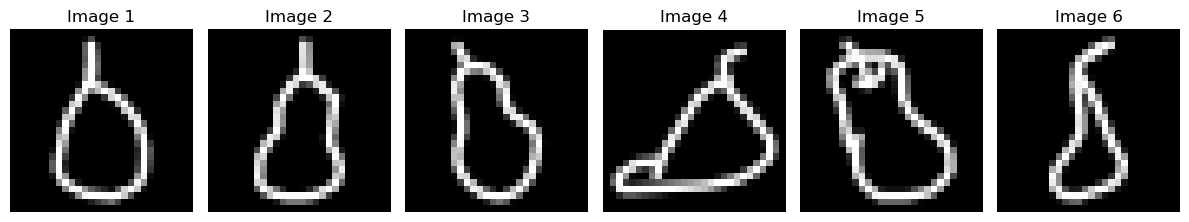

Visualizing images from: eye.npy
Loaded data/eye.npy with shape: (125888, 784)


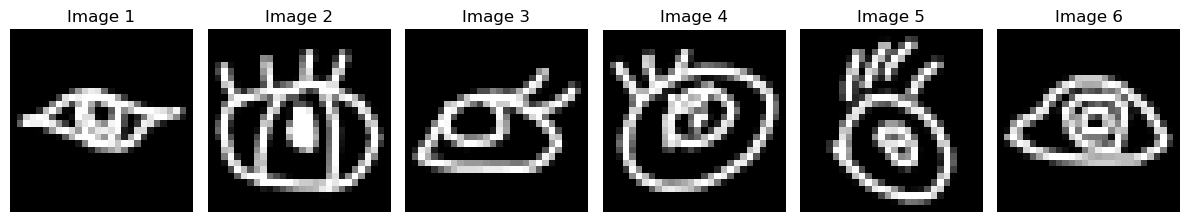

Visualizing images from: flower.npy
Loaded data/flower.npy with shape: (144818, 784)


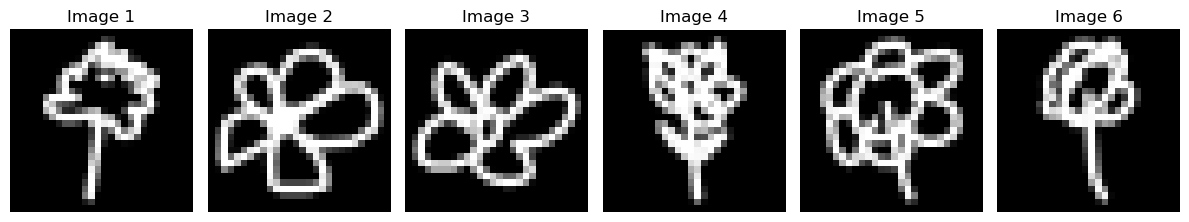

Visualizing images from: star.npy
Loaded data/star.npy with shape: (137619, 784)


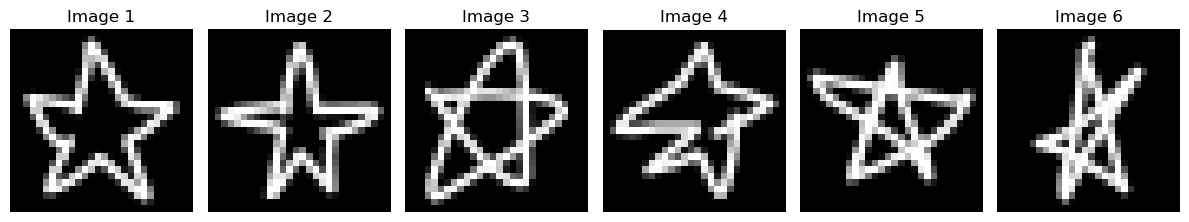

Visualizing images from: sun.npy
Loaded data/sun.npy with shape: (133781, 784)


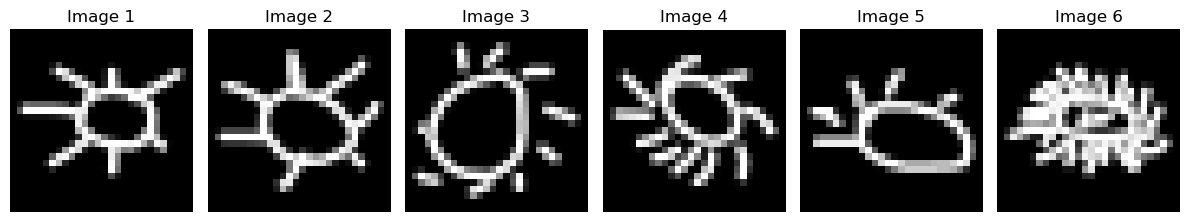

Visualizing images from: book.npy
Loaded data/book.npy with shape: (119364, 784)


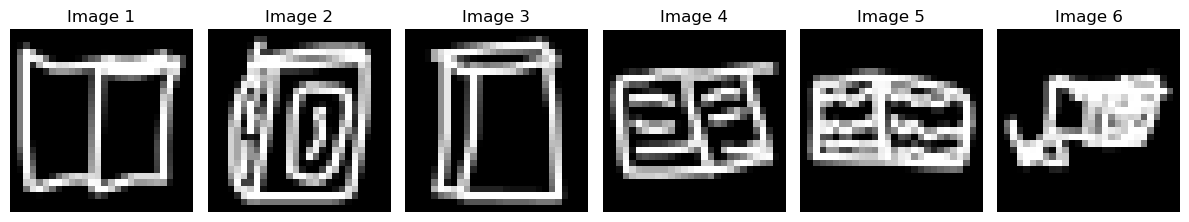

Visualizing images from: radio.npy
Loaded data/radio.npy with shape: (135728, 784)


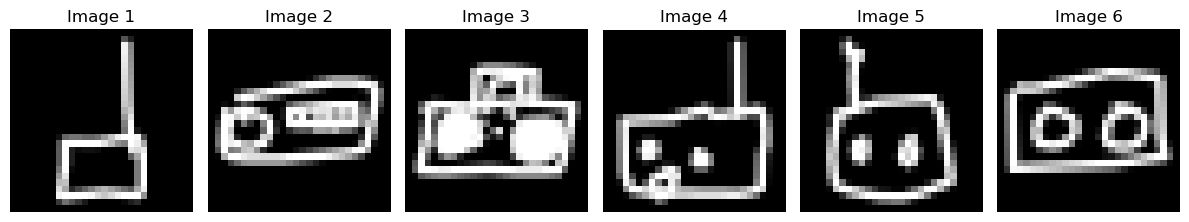

Visualizing images from: piano.npy
Loaded data/piano.npy with shape: (116870, 784)


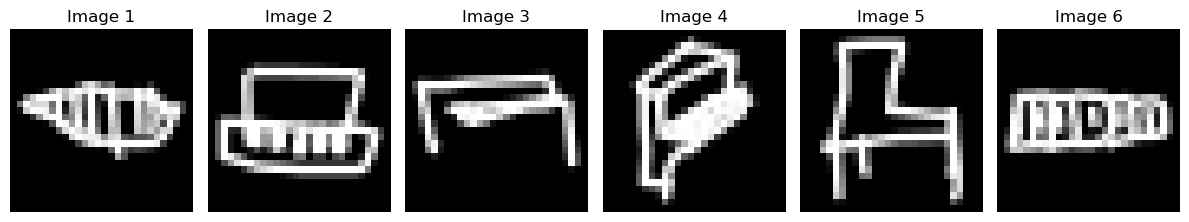

Visualizing images from: spider.npy
Loaded data/spider.npy with shape: (209447, 784)


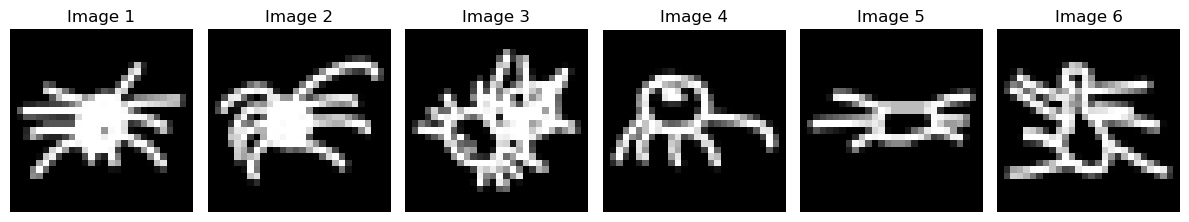

Visualizing images from: crayon.npy
Loaded data/crayon.npy with shape: (129953, 784)


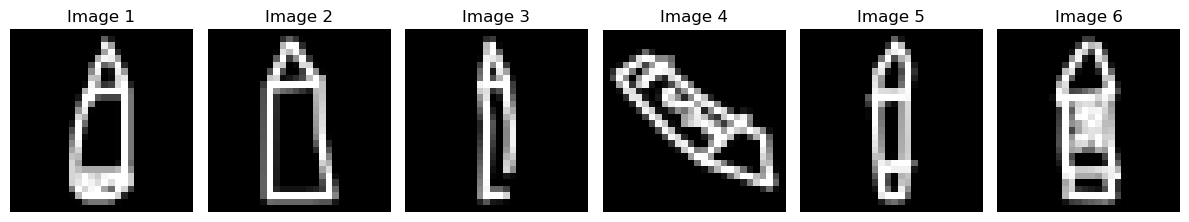

Visualizing images from: face.npy
Loaded data/face.npy with shape: (161666, 784)


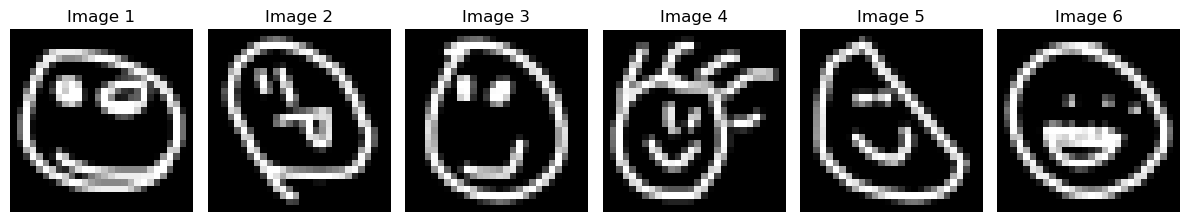

In [3]:
# Function to visualize images from an .npy file
def visualize_npy_images(file_path, num_images=6):
    # Load the image data from the .npy file
    data = np.load(file_path)
    print(f"Loaded {file_path} with shape: {data.shape}")

    # Display the first `num_images` images
    plt.figure(figsize=(12, 6))  # Set the size of the figure
    for i in range(num_images):
        image = data[i].reshape(28, 28)  # Reshape the flattened image to 28x28
        plt.subplot(1, num_images, i + 1)  # Create subplots
        plt.imshow(image, cmap='gray')  # Display the image in grayscale
        plt.title(f"Image {i + 1}")  # Set title for each image
        plt.axis('off')  # Remove axes for a cleaner look
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()  # Display the images

# Directory containing the .npy files
data_dir = 'data'

# List all .npy files in the directory
npy_files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]

# Visualize images from each .npy file
for npy_file in npy_files:
    file_path = os.path.join(data_dir, npy_file)  # Full path to the .npy file
    print(f"Visualizing images from: {npy_file}")
    visualize_npy_images(file_path, num_images=6)  # Display 6 images from the file


## Loading Data
For the MLP architecture used in the tutorial, the data needs to be in 1D format (a flattened vector) and normalized.

- The code loads data from .npy files, normalizes it, and prepares it as 1D input for the MLP.
- The tutorial's build_model architecture works with flattened data (1D), so 28x28 images are converted to 784 elements.
- The DataLoader simplifies the training process by creating manageable batches.

In [4]:
def load_and_prepare_quickdraw_data(categories, data_dir='data', max_samples=3000):
    X = []
    y = []
    
    for idx, class_name in enumerate(categories):
        file_path = os.path.join(data_dir, f"{class_name}.npy")
        if os.path.exists(file_path):
            print(f"Loading {file_path}")
            data = np.load(file_path)[:max_samples]  # Load only max_samples examples
            X.append(data)
            y.append(np.full((data.shape[0],), idx))  # Matching labels
        else:
            print(f"File not found: {file_path}")
    
    # Concatenate data and labels
    # X = np.vstack(X).astype(np.float32) / 255.0  # Normalization
    X = (np.vstack(X).astype(np.float32) / 255.0 - 0.5) / 0.5
    y = np.concatenate(y).astype(np.int64)
    
    # Convert to Tensor
    X_tensor = torch.tensor(X)
    y_tensor = torch.tensor(y)
    
    print("Data prepared successfully!")
    return X_tensor, y_tensor

# Load and prepare data (limiting to 3000 examples per class)
X, y = load_and_prepare_quickdraw_data(categories, max_samples=5000)

Loading data/apple.npy
Loading data/book.npy
Loading data/cannon.npy
Loading data/crayon.npy
Loading data/eye.npy
Loading data/face.npy
Loading data/flower.npy
Loading data/nail.npy
Loading data/pear.npy
Loading data/piano.npy
Loading data/radio.npy
Loading data/spider.npy
Loading data/star.npy
Loading data/sun.npy
Data prepared successfully!


## Defining the Model - MLP (Multi-Layer Perceptron)
MLP is an artificial neural network composed of multiple fully connected layers. Each layer is formed by neurons, which calculate a linear combination of the inputs followed by a non-linear activation function, such as ReLU (Rectified Linear Unit).

- MLP is a feedforward neural network composed of fully connected layers.
- It is suitable for tabular or flat data (such as raster images).
- Although simple, MLP works well for tasks such as classifying small images, such as QuickDraw.
- For more complex or larger data, CNNs are generally more efficient.

The model accepts flattened images (1D) as input and passes them through multiple fully connected layers with ReLU activations, Batch Normalization, and optional Dropout for regularization.

Builds a fully connected feedforward neural network.

    Parameters:
    - input_size (int): Number of input features (e.g., 28x28 images flattened to 784).
    - output_size (int): Number of classes (e.g., 10 classes for QuickDraw categories).
    - hidden_sizes (list): List of integers defining the size of each hidden layer.
    - dropout (float): Dropout probability for regularization (default is 0.0).

    Returns:
    - model (torch.nn.Module): A PyTorch sequential model.

In [ ]:
from collections import OrderedDict

def build_model(input_size, output_size, hidden_sizes, dropout=0.0):
    # Define the ordered layers for the feedforward network
    model = nn.Sequential(OrderedDict([
        # First fully connected layer
        ('fc1', nn.Linear(input_size, hidden_sizes[0])),
        ('relu1', nn.ReLU()),  # Activation function
        ('bn1', nn.BatchNorm1d(hidden_sizes[0])),  # Batch Normalization
        ('dropout1', nn.Dropout(dropout)),  # Dropout layer
        
        # Second fully connected layer
        ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
        ('relu2', nn.ReLU()),
        ('bn2', nn.BatchNorm1d(hidden_sizes[1])),
        ('dropout2', nn.Dropout(dropout)),

        # Third fully connected layer
        ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
        ('relu3', nn.ReLU()),
        ('bn3', nn.BatchNorm1d(hidden_sizes[2])),
        ('dropout3', nn.Dropout(dropout)),

        # Final output layer (logits for classification)
        ('logits', nn.Linear(hidden_sizes[2], output_size))
    ]))

    return model

# Example parameters for the QuickDraw dataset
input_size = 784  # 28x28 flattened images
output_size = len(categories)  # Number of classes
hidden_sizes = [512, 256, 128]  # Hidden layers with decreasing sizes
dropout = 0.2  # Dropout probability for regularization

# Build the model
model = build_model(input_size, output_size, hidden_sizes, dropout)

# Print the model architecture to verify
print(model)


Using device: mps
Sequential(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (relu3): ReLU()
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (logits): Linear(in_features=128, out_features=14, bias=True)
)


## Training the Model

Loss Function:

- CrossEntropyLoss: This is the standard loss function for multi-class classification tasks. It combines Softmax and Negative Log-Likelihood Loss.

Optimizer:

- SGD with momentum: Momentum helps accelerate the convergence by dampening oscillations during training.

Training Loop:

- Flattening Input: The input images are reshaped from (batch_size, 1, 28, 28) to (batch_size, 784) to match the MLP's input size.
- Forward Pass: The input is passed through the model to obtain logits.
- Loss Computation: The loss is calculated using criterion.
- Backward Pass: Gradients are computed using loss.backward().
- Parameter Update: The optimizer updates the model parameters.
- Loss Tracking: The running loss is averaged across all batches for each epoch.

In [11]:
# Select device: MPS for Apple Silicon, otherwise CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD optimizer with momentum

# Split the dataset into train and validation sets (80% train, 20% validation)
val_size = int(0.2 * len(X))  # 20% for validation
train_size = len(X) - val_size
train_dataset, val_dataset = random_split(TensorDataset(X, y), [train_size, val_size])

# Create DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Move the model to the selected device
model = model.to(device)

# Lists to store losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

# Training loop with validation
num_epochs = 20
print("Starting training...")

for epoch in range(1, num_epochs + 1):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0

    # Training step
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        images = images.view(images.size(0), -1)  # Flatten the images to (batch_size, 784)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device
            images = images.view(images.size(0), -1)  # Flatten for MLP
            
            logits = model(images)
            loss = criterion(logits, labels)

            running_val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct / total * 100

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print results for this epoch
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n")

print("Training complete!")

Using device: mps
Starting training...
Epoch 1/20
Train Loss: 0.9740, Val Loss: 0.7035, Val Accuracy: 78.15%

Epoch 2/20
Train Loss: 0.7839, Val Loss: 0.6510, Val Accuracy: 80.08%

Epoch 3/20
Train Loss: 0.7191, Val Loss: 0.6227, Val Accuracy: 81.01%

Epoch 4/20
Train Loss: 0.6881, Val Loss: 0.5924, Val Accuracy: 81.72%

Epoch 5/20
Train Loss: 0.6582, Val Loss: 0.5797, Val Accuracy: 82.36%

Epoch 6/20
Train Loss: 0.6345, Val Loss: 0.5754, Val Accuracy: 81.98%

Epoch 7/20
Train Loss: 0.6108, Val Loss: 0.5592, Val Accuracy: 82.84%

Epoch 8/20
Train Loss: 0.5972, Val Loss: 0.5786, Val Accuracy: 82.29%

Epoch 9/20
Train Loss: 0.5824, Val Loss: 0.5611, Val Accuracy: 82.48%

Epoch 10/20
Train Loss: 0.5628, Val Loss: 0.5460, Val Accuracy: 83.36%

Epoch 11/20
Train Loss: 0.5535, Val Loss: 0.5386, Val Accuracy: 83.54%

Epoch 12/20
Train Loss: 0.5452, Val Loss: 0.5332, Val Accuracy: 83.60%

Epoch 13/20
Train Loss: 0.5366, Val Loss: 0.5333, Val Accuracy: 83.71%

Epoch 14/20
Train Loss: 0.5307, Va

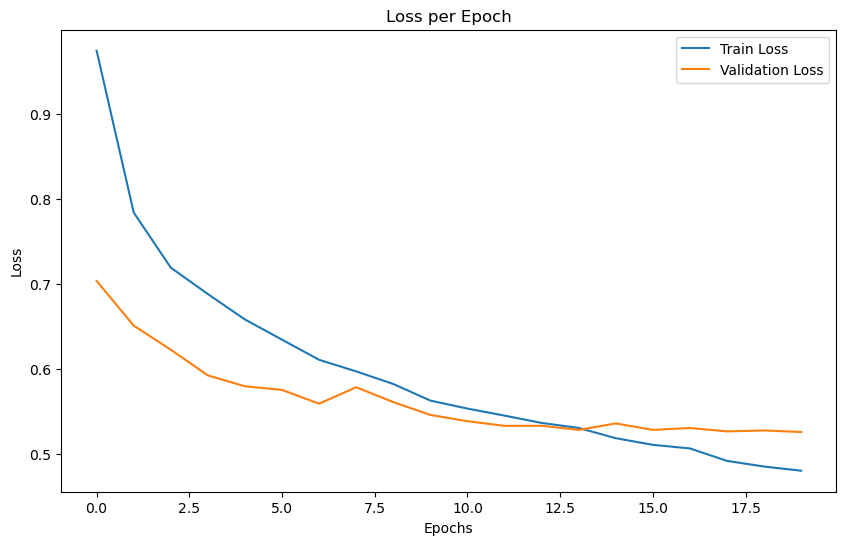

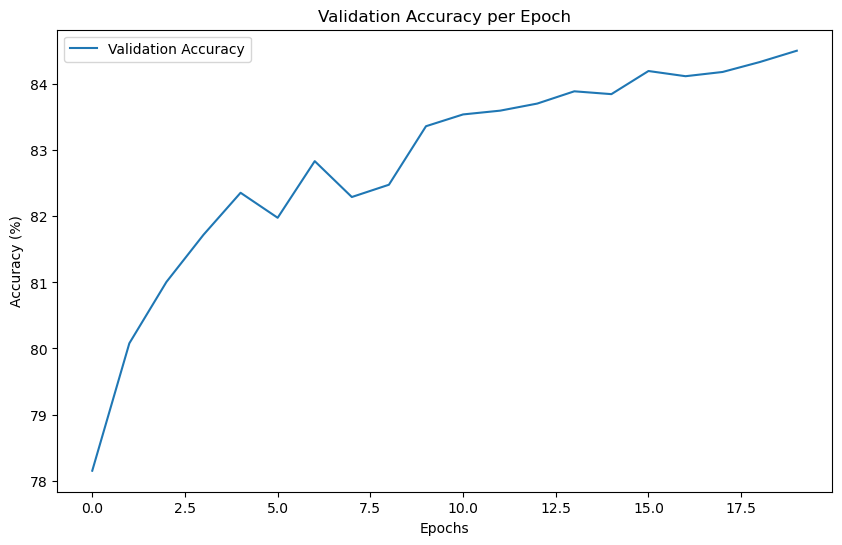

In [12]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

# Plot validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy per Epoch")
plt.legend()
plt.show()

## Evaluate the Model

Evaluates the model's performance on the test set.

    Parameters:
    - model (torch.nn.Module): The trained model to be evaluated.
    - test_loader (DataLoader): DataLoader containing the test data.

    Returns:
    - accuracy (float): The accuracy of the model on the test set.
    - predictions (list): List of tuples (image, label, predicted_label) for visualization.

Plots a grid of sample images with their true and predicted labels.

    Parameters:
    - predictions (list): List of tuples (image, true_label, predicted_label).
    - label_dict (dict): Mapping of class indices to class names.
    - num_samples (int): Number of images to display.

Plots a histogram of the predicted classes.

    Parameters:
    - predictions (list): List of tuples (image, true_label, predicted_label).
    - label_dict (dict): Mapping of class indices to class names.


Model Accuracy on Test Set: 89.81%


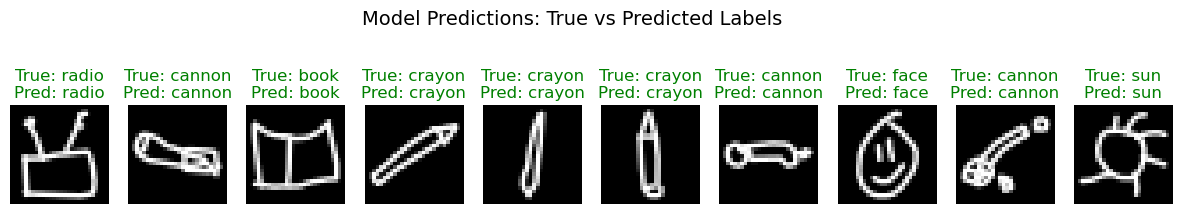

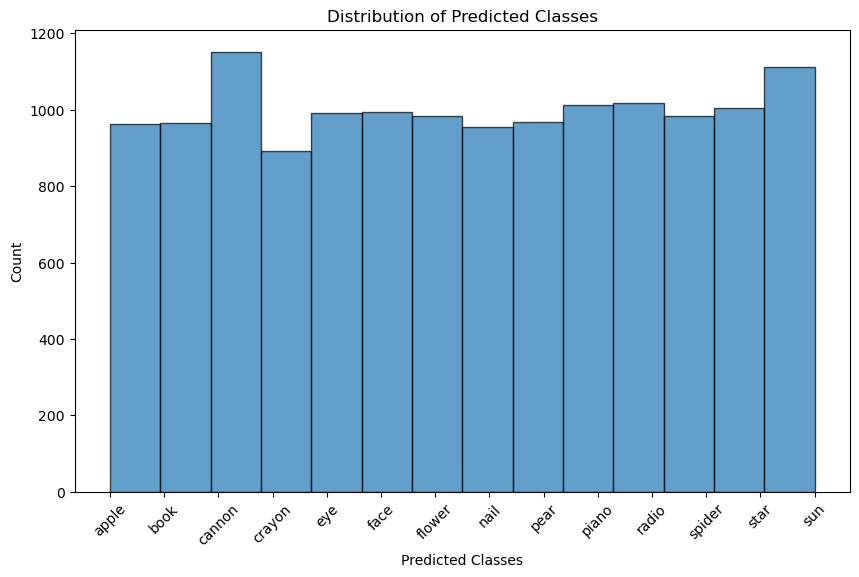

In [18]:
# Split the data into train and test sets (80% train, 20% test)
test_size = int(0.2 * len(X))  # 20% for testing
train_size = len(X) - test_size

train_dataset, test_dataset = random_split(TensorDataset(X, y), [train_size, test_size])

# DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predictions = []

    with torch.no_grad():  # Turn off gradient computation during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Flatten the input images
            images = images.view(images.size(0), -1)

            # Forward pass
            logits = model(images)

            # Get predictions (class with the highest probability)
            _, predicted = torch.max(logits, dim=1)

            # Store predictions for visualization
            for img, label, pred in zip(images, labels, predicted):
                predictions.append((img, label.item(), pred.item()))

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    return accuracy, predictions

# Evaluate the model
test_accuracy, predictions = evaluate_model(model, test_loader)
print(f"Model Accuracy on Test Set: {test_accuracy:.2%}")

# Visualize some predictions
def plot_predictions(predictions, label_dict, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    fig.suptitle("Model Predictions: True vs Predicted Labels", fontsize=14)

    for i, ax in enumerate(axes):
        if i >= len(predictions):
            break
        img, true_label, pred_label = predictions[i]

        # Move tensor to CPU and convert to NumPy
        img_cpu = img.cpu().view(28, 28).numpy()

        ax.imshow(img_cpu, cmap='gray')  # Reshape to 28x28 for visualization
        ax.axis('off')
        ax.set_title(f"True: {label_dict[true_label]}\nPred: {label_dict[pred_label]}",
                     color="green" if true_label == pred_label else "red")

    plt.show()

# Plot predictions
plot_predictions(predictions, label_dict, num_samples=10)

# Plot distribution of predictions
def plot_prediction_distribution(predictions, label_dict):
    pred_labels = [pred[2] for pred in predictions]  # Extract predicted labels
    plt.figure(figsize=(10, 6))
    plt.hist(pred_labels, bins=len(label_dict), edgecolor='black', alpha=0.7)
    plt.xticks(range(len(label_dict)), label_dict.values(), rotation=45)
    plt.xlabel("Predicted Classes")
    plt.ylabel("Count")
    plt.title("Distribution of Predicted Classes")
    plt.show()

# Plot prediction distribution
plot_prediction_distribution(predictions, label_dict)



Evaluates the model on the test set and generates a classification report and confusion matrix.

    Parameters:
    - model (torch.nn.Module): The trained model to evaluate.
    - test_loader (DataLoader): DataLoader containing the test data.
    - class_names (list): List of class names for the labels.

    Outputs:
    - Prints a classification report.
    - Plots a confusion matrix.


Classification Report:
              precision    recall  f1-score   support

       apple       0.94      0.95      0.95       961
        book       0.92      0.90      0.91       991
      cannon       0.82      0.91      0.86      1040
      crayon       0.91      0.83      0.87       975
         eye       0.92      0.91      0.92      1001
        face       0.90      0.94      0.92       949
      flower       0.92      0.93      0.92       983
        nail       0.84      0.83      0.84       962
        pear       0.96      0.91      0.94      1021
       piano       0.85      0.87      0.86       983
       radio       0.94      0.93      0.93      1031
      spider       0.84      0.81      0.83      1020
        star       0.94      0.92      0.93      1024
         sun       0.88      0.93      0.90      1059

    accuracy                           0.90     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.90      0.90      0.90     14000



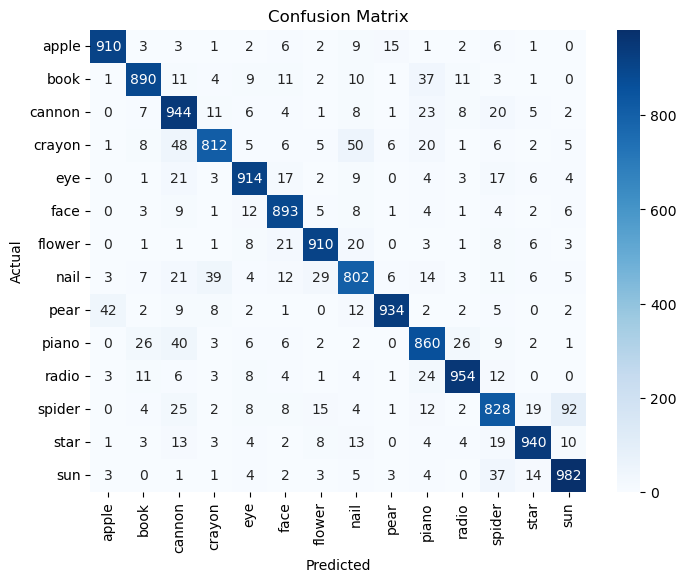

In [19]:
def evaluate_model_with_metrics(model, test_loader, class_names):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            # Flatten images to match input size (if using MLP)
            images = images.view(images.size(0), -1)
            
            # Forward pass
            logits = model(images)
            _, predicted = torch.max(logits, dim=1)
            
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())  # Move to CPU and convert to NumPy
            all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Class names (matching label_dict from earlier)
class_names = list(label_dict.values())  # ['cannon', 'eye', ..., 'sword']

# Evaluate the model and generate metrics
evaluate_model_with_metrics(model, test_loader, class_names)


## Save the Model

In [20]:
# Save the trained model's state_dict
torch.save(model.state_dict(), 'model_weights.pth')
print("Model weights saved successfully!")

Model weights saved successfully!


## Test with new images

Preprocess the input image:
1. Convert to grayscale.
2. Extract the bounding box of the content and add padding to focus on the drawing.
3. Invert the colors (black becomes white, and white becomes black).
4. Resize to 28x28 pixels.
5. Normalize to match the model's input requirements [-1, 1].

 Args:
        image_path (str): Path to the input image.
        padding (int): Padding to add around the bounding box.

    Returns:
        Tensor: Preprocessed image tensor ready for the model.


Load the trained model with its saved state_dict.

    Args:
        model_path (str): Path to the saved model weights.
        input_size (int): Input size of the model.
        output_size (int): Number of output classes.
        hidden_sizes (list): Sizes of the hidden layers.
        dropout (float): Dropout probability.

    Returns:
        model (torch.nn.Module): Loaded PyTorch model.

Perform prediction on a single preprocessed image.

    Args:
        model (torch.nn.Module): The trained model.
        image_tensor (Tensor): Preprocessed image tensor.
        label_dict (dict): Dictionary mapping class indices to class names.

    Returns:
        str: Predicted class name.


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_69202/332073687.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

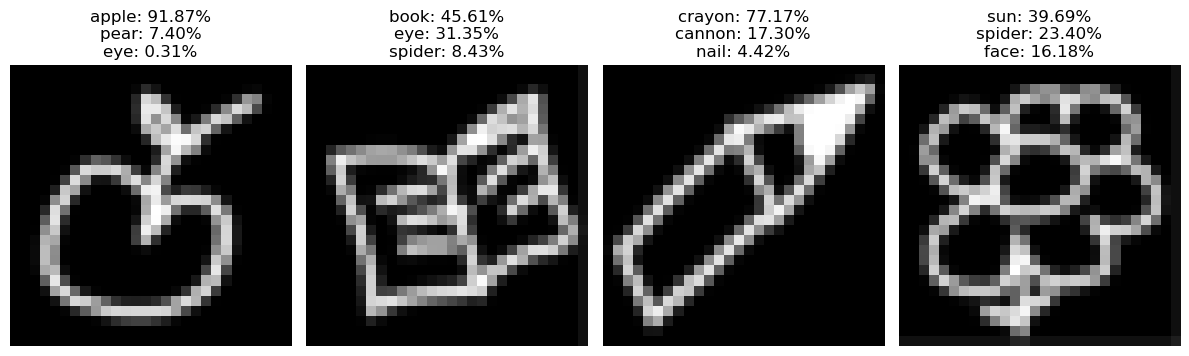

In [30]:
# Define the preprocessing function
def preprocess_inverted_binary_image(image_path, padding=10):

    # Open the image and convert to grayscale
    image = Image.open(image_path).convert('L')  # 'L' mode ensures grayscale

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Create a binary mask for non-white areas (content of the image)
    non_white_mask = image_array < 255  # Pixels with values < 255 are considered "content"

    # Find the bounding box of the content
    coords = np.argwhere(non_white_mask)  # Coordinates where mask is True
    if coords.size > 0:
        x_min, y_min = coords.min(axis=0)
        x_max, y_max = coords.max(axis=0)

        # Add padding to the bounding box
        x_min = max(x_min - padding, 0)
        y_min = max(y_min - padding, 0)
        x_max = min(x_max + padding, image_array.shape[0])
        y_max = min(y_max + padding, image_array.shape[1])

        # Crop the bounding box
        cropped_image = image.crop((y_min, x_min, y_max + 1, x_max + 1))
    else:
        # If no content, use the original image
        cropped_image = image

    # Invert the colors: white (255) → black (0), and everything else → white (255)
    cropped_array = np.array(cropped_image)
    inverted_array = np.where(cropped_array == 255, 0, 255).astype(np.uint8)

    # Convert back to a PIL image
    inverted_image = Image.fromarray(inverted_array)

    # Preprocessing pipeline
    preprocess = transforms.Compose([
        transforms.Resize((28, 28)),         # Resize to 28x28 pixels
        transforms.ToTensor(),               # Convert to tensor (values [0, 1])
        transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1]
    ])

    # Apply preprocessing
    preprocessed_image = preprocess(inverted_image)
    return preprocessed_image

# Load the trained model
def load_trained_model(model_path, input_size, output_size, hidden_sizes, dropout=0.2):
    model = build_model(input_size, output_size, hidden_sizes, dropout)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Predict function with top-3 probabilities
def predict_top3(model, image_tensor, label_dict):
    """
    Predict the top-3 classes for a given image tensor.

    Args:
        model (torch.nn.Module): The trained model.
        image_tensor (Tensor): Preprocessed image tensor.
        label_dict (dict): Dictionary mapping class indices to class names.

    Returns:
        list: List of tuples (class_name, probability) for the top-3 predictions.
    """
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        logits = model(image_tensor.view(1, -1))  # Flatten the image for MLP
        probabilities = F.softmax(logits, dim=1)  # Apply softmax to get probabilities
        top3_prob, top3_classes = torch.topk(probabilities, 3)  # Get top-3 predictions

    # Convert to readable format
    top3 = [(label_dict[idx.item()], prob.item() * 100) for idx, prob in zip(top3_classes[0], top3_prob[0])]
    return top3

# Paths to images
image_files = ['apple.png', 'book.png', 'crayon.png', 'flower.png']
model_path = 'model_weights.pth'  # Path to the saved model weights

# Updated categories and label dictionary
categories = ['apple', 'book', 'cannon', 'crayon', 'eye', 'face', 'flower',
              'nail', 'pear', 'piano', 'radio', 'spider', 'star', 'sun']
label_dict = {idx: category for idx, category in enumerate(categories)}

# Load the model
input_size = 784  # 28x28 flattened input
output_size = len(categories)
hidden_sizes = [512, 256, 128]
model = load_trained_model(model_path, input_size, output_size, hidden_sizes)

# Preprocess images, make predictions, and display results
plt.figure(figsize=(12, 6))
for i, image_path in enumerate(image_files):
    if os.path.exists(image_path):
        try:
            # Preprocess the image
            preprocessed_image = preprocess_inverted_binary_image(image_path, padding=25)

            # Predict the top-3 classes
            top3_predictions = predict_top3(model, preprocessed_image, label_dict)

            # Display the image and predictions
            plt.subplot(1, len(image_files), i + 1)
            plt.imshow(preprocessed_image.squeeze(0).cpu(), cmap='gray')
            title = "\n".join([f"{cls}: {prob:.2f}%" for cls, prob in top3_predictions])
            plt.title(title)
            plt.axis('off')
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    else:
        print(f"Image not found: {image_path}")

plt.tight_layout()
plt.show()